<a href="https://colab.research.google.com/github/zxytimes/R-for-data-science/blob/main/%E2%80%9Cgaussian_processes_classification_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/krasserm/bayesian-machine-learning/blob/dev/gaussian-processes/gaussian_processes_classification.ipynb)

In [2]:
try:
    # Check if notebook is running in Google Colab
    import google.colab
    # Get additional files from Github
    !wget https://raw.githubusercontent.com/krasserm/bayesian-machine-learning/dev/gaussian-processes/gaussian_processes_util.py
except:
    pass

--2023-01-07 14:37:54--  https://raw.githubusercontent.com/krasserm/bayesian-machine-learning/dev/gaussian-processes/gaussian_processes_util.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3842 (3.8K) [text/plain]
Saving to: ‘gaussian_processes_util.py.1’

gaussian_processes_ 100%[===================>]   3.75K  --.-KB/s    in 0s      

2023-01-07 14:37:54 (40.3 MB/s) - ‘gaussian_processes_util.py.1’ saved [3842/3842]



# Gaussian processes for classification

This article gives an introduction to Gaussian processes for classification and provides a minimal implementation with NumPy. Gaussian processes for regression are covered in a [previous article](https://nbviewer.jupyter.org/github/krasserm/bayesian-machine-learning/blob/dev/gaussian-processes/gaussian_processes.ipynb?flush_cache=true) and a brief recap is given in the next section.

## Regression recap

A Gaussian process (GP) for regression is a [random process](https://en.wikipedia.org/wiki/Stochastic_process) where any point $\mathbf{x} \in \mathbb{R}^d$ is assigned a random variable $f(\mathbf{x})$ and where the joint distribution of a finite number of these variables $p(f(\mathbf{x}_1),...,f(\mathbf{x}_N))$ is itself Gaussian:

$$
p(\mathbf{f} \mid \mathbf{X}) = \mathcal{N}(\mathbf{f} \mid \boldsymbol\mu, \mathbf{K})
\tag{1}
$$

A GP is a prior over functions whose shape (smoothness, ...) is defined by $\mathbf{K} = \kappa(\mathbf{X}, \mathbf{X})$ where $\kappa$ is a parameteric kernel function. It is common to set $\boldsymbol\mu = \mathbf{0}$. Given observed noisy function values $\mathbf{y}$ at points $\mathbf{X}$ we want to predict a noise-free function value $f_*$ at point $\mathbf{x}_*$. The joint distribution of observed values $\mathbf{y}$ and prediction $f_*$ is also a Gaussian:

$$
p(\mathbf{y}, f_* \mid \mathbf{X},\mathbf{x}_*) = 
\mathcal{N} \left(
\begin{pmatrix}\mathbf{y} \\ f_*\end{pmatrix} \middle| \ \boldsymbol{0},
\begin{pmatrix}\mathbf{K}_y & \mathbf{k}_* \\ \mathbf{k}_*^T & k_{**}\end{pmatrix}
\right)
\tag{2}
$$

where $\mathbf{K}_y = \mathbf{K} + \sigma_y^2\mathbf{I}$, $\mathbf{k}_* = \kappa(\mathbf{X},\mathbf{x}_*)$ and $k_{**} = \kappa(\mathbf{x}_*,\mathbf{x}_*)$. $\sigma_y^2$ models noise in the observed function values $\mathbf{y}$. Turning the joint distribution $(2)$ into a conditional distribution we obtain a predictive distribution

$$
p(f_* \mid \mathbf{x}_*, \mathbf{X}, \mathbf{y}) = \mathcal{N}(f_* \mid \boldsymbol\mu_*, \boldsymbol\Sigma_*)
\tag{3}
$$

with

$$
\begin{align*}
\boldsymbol{\mu_*} &= \mathbf{k}_*^T \mathbf{K}_y^{-1} \mathbf{y}\tag{4} \\
\boldsymbol{\Sigma_*} &= k_{**} - \mathbf{k}_*^T \mathbf{K}_y^{-1} \mathbf{k}_*\tag{5}
\end{align*}
$$

In contrast to the notation in the [previous article](https://nbviewer.jupyter.org/github/krasserm/bayesian-machine-learning/blob/dev/gaussian-processes/gaussian_processes.ipynb?flush_cache=true), I'm using here a single test input $\mathbf{x}_*$ to be consistent with the notation in the following sections. However, the implementation further below is vectorized so that predictions can be made for multiple test inputs $\mathbf{X}_*$ in a single operation.


## Binary classification

In context of binary classification, we have a discrete target variable $t \in \{0, 1 \}$ that follows a Bernoulli distribution. We are interested in the probability $p(t=1 \mid a) = \sigma(a)$ where $\sigma$ is the logistic sigmoid function taking logit $a \in \mathbb{R}$ as argument. $p(t=0 \mid a)$ is given by $1 - p(t=1 \mid a)$.

### Predictive distribution

Given observed targets $\mathbf{t}$ at points $\mathbf{X}$, our goal is to predict target $t_*$ at point $\mathbf{x}_*$ using the predictive distribution $p(t_*=1 \mid \mathbf{x}_*, \mathbf{X}, \mathbf{t})$. Making the conditioning on input variables implicit, the notation of the predictive distribution simplifies to $p(t_*=1 \mid \mathbf{t})$.

In the following, I will only outline the high-level steps needed to derive an expression for the predictive distribution and only present those results that are relevant for a minimal implementation. A detailed derivation of these results is given in \[1\], \[2\] and \[3\]. The predictive distribution can be defined as:

$$
p(t_*=1 \mid \mathbf{t}) = \int{p(t_*=1 \mid a_*) p(a_* \mid \mathbf{t}) d a_*}
\tag{6}
$$

This integral is analytically intractable. Two approximation are needed to make it tractable. First, $p(a_* \mid \mathbf{t})$ must be approximated with a Gaussian distribution. Second, $p(t_*=1 \mid a_*) = \sigma(a_*)$ must be approximated with the inverse probit function $\Phi(a_*)$ (see also \[2\] section 4.3.5). Let's start with $p(a_* \mid \mathbf{t})$ which can be defined as:

$$
p(a_* \mid \mathbf{t}) = \int{p(a_* \mid \mathbf{a}) p(\mathbf{a} \mid \mathbf{t}) d\mathbf{a}}
\tag{7}
$$

The first term inside the integral, $p(a_* \mid \mathbf{a})$, is a Gaussian distribution that can be obtained using a GP for regression. The joint distribution over logits $p(\mathbf{a}, a_* \mid \mathbf{X}, \mathbf{x}_*)$ is given by Equation $(2)$ which can be turned into a conditional distribution $p(a_* \mid \mathbf{x}_*, \mathbf{X}, \mathbf{a})$ using Equation $(3)$. Making the conditioning on input variables implicit gives $p(a_* \mid \mathbf{a})$. Instead of $\mathbf{K}_y$ used in Equation $(2)$ we use $\mathbf{K}_a = \mathbf{K} + \sigma_a^2\mathbf{I}$. Assuming that training data are correctly labeled, we could set noise parameter $\sigma_a^2$ to zero but for reasons of numerical stability it is convenient to set it to a small value. Using the Laplace approximation (see \[2\] section 4.4), the posterior distribution $p(\mathbf{a} \mid \mathbf{t})$ can be approximated with a Gaussian distribution $q(\mathbf{a})$:

$$
q(\mathbf{a}) = \mathcal{N}(\mathbf{a} \mid \hat{\mathbf{a}}, \mathbf{H}^{-1})
\tag{8}
$$

where $\mathbf{H} = \mathbf{W} + \mathbf{K}_a^{-1}$. $\mathbf{W}$ is a diagonal matrix with elements $\sigma(a_n)(1 - \sigma(a_n))$ with $a_n$ being the elements of $\mathbf{a}$. Written in vector notation the diagonal is $\boldsymbol\sigma(\mathbf{1}-\boldsymbol\sigma)$. The mean $\hat{\mathbf{a}}$ can be obtained iteratively with the following update equation:

$$
\mathbf{a}^{\text{new}} = \mathbf{K}_a (\mathbf{I} + \mathbf{W}\mathbf{K}_a)^{-1}(\mathbf{t} - \boldsymbol\sigma + \mathbf{W}\mathbf{a})
\tag{9}
$$

At convergence $\hat{\mathbf{a}} = \mathbf{a}^{\text{new}}$. With two Gaussians inside the integral of Equation $(7)$ the result is also a Gaussian and can be obtained analytically. The Gaussian approximation of $p(a_* \mid \mathbf{t})$ is therefore given by


$$
p(a_* \mid \mathbf{t}) \approx \mathcal{N}(a_* \mid \mu_{a_*}, \sigma_{a_*}^2)
\tag{10}
$$

with 

$$
\begin{align*}
\mu_{a_*} &= \mathbf{k}_*^T(\mathbf{t} - \boldsymbol\sigma)\tag{11} \\
\sigma_{a_*}^2 &= k_{**} - \mathbf{k}_*^T (\mathbf{W}^{-1} + \mathbf{K}_a)^{-1} \mathbf{k}_*\tag{12}
\end{align*}
$$

Finally, we approximate $p(t_*=1 \mid a_*)$ in Equation $(6)$ with the inverse probit function $\Phi(a_*)$ so that the predictive distribution can be approximated with:

$$
p(t_*=1 \mid \mathbf{t}) \approx \sigma(\mu_{a_*} (1 + \pi\sigma_{a_*}^2 / 8)^{-1/2})
\tag{13}
$$

See \[2\] section 4.5.2 for further details about the probit approximation.

### Kernel parameter optimization

Kernel parameters $\boldsymbol\theta$ can be optimized by maximizing the log marginal likelihood log $p(\mathbf{t} \mid \boldsymbol\theta)$. Using again the Laplace approximation $q(\mathbf{a})$ for posterior $p(\mathbf{a} \mid \mathbf{t})$ the log marginal likelihood can be approximated with:

$$
p(\mathbf{t} \mid \boldsymbol\theta) \approx 
\mathbf{t}^T \hat{\mathbf{a}}
-\frac{1}{2} \hat{\mathbf{a}}^T \mathbf{K}_a^{-1} \hat{\mathbf{a}}
-\frac{1}{2} \log \begin{vmatrix}\mathbf{K}_a\end{vmatrix}
-\frac{1}{2} \log \begin{vmatrix}\mathbf{W} + \mathbf{K}_a^{-1}\end{vmatrix}
- \sum_{n=1}^{N} \log(1 + e^{\hat{a}_n})
\tag{14}
$$

where $N$ is the size of the training dataset. Since $\hat{\mathbf{a}}$ also depends on $\boldsymbol\theta$, $\hat{\mathbf{a}}$ must be re-estimated using Equation $(9)$ at each optimization step.

## Multi-class classification

For multi-class classification one option is to use several binary one-versus-rest classifiers. This approach, for example, is taken by [`GaussianProcessClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessClassifier.html) of scikit-learn and can also be applied to the implementation presented here. An extension to true multi-class classification is also possible <sup>[1],[3]</sup> but not covered in this article.

## Implementation with Numpy

This is the minimum we need to know for implementing GPs for binary classification. The following implementation vectorizes the computation of $p(t_*=1 \mid \mathbf{t})$ so that we can make predictions at multiple test inputs `X_test` in a single operation. The results are compared with those of `GaussianProcessClassifier`. The implementation presented here directly follows the definition of equations which works quite well for many cases. Numerically more stable implementation options are described in \[1\] and \[3\]. These have also been used for `GaussianProcessClassifier`, for example.

In [15]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from scipy.stats import bernoulli
from scipy.special import expit as sigmoid

from sklearn.datasets import make_moons
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

%matplotlib inline

### 1D dataset

Let's start with a simple 1D training dataset where logits $\mathbf{a}$ are given by a sine function. Target values $\mathbf{t}$ are sampled from a corresponding Bernoulli distribution. In the following we still assume that training data are correctly labeled.

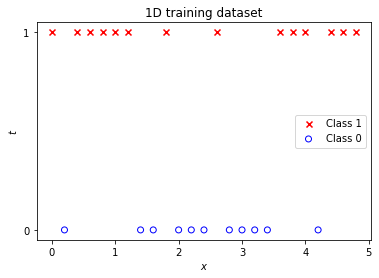

In [4]:
np.random.seed(0)

X = np.arange(0, 5, 0.2).reshape(-1, 1)
X_test = np.arange(-2, 7, 0.1).reshape(-1, 1)

a = np.sin(X * np.pi * 0.5) * 2
t = bernoulli.rvs(sigmoid(a))

plot_data_1D(X, t)
plt.title('1D training dataset')
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.yticks([0, 1])
plt.legend();

### Training

As in [Gaussian processes](https://nbviewer.jupyter.org/github/krasserm/bayesian-machine-learning/blob/dev/gaussian-processes/gaussian_processes.ipynb?flush_cache=true) for regression, we again use a squared exponential kernel with length parameter `theta[0]` and multiplicative constant `theta[1]`.

In [5]:
def kernel(X1, X2, theta):
    """
    Isotropic squared exponential kernel.

    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).
        theta: Kernel parameters

    Returns:
        (m x n) matrix
    """

    sqdist = np.sum(X1 ** 2, 1).reshape(-1, 1) + np.sum(X2 ** 2, 1) - 2 * np.dot(X1, X2.T)
    return theta[1] ** 2 * np.exp(-0.5 / theta[0] ** 2 * sqdist)

Helpers `K_` and `W_` ease the computation of matrices $\mathbf{K} + \nu \mathbf{I}$ and $\mathbf{W}$, respectively ($\nu$ is set to a small value for numerical stability). `K_` also provides an efficient implementation for computing the diagonal (needed when making predictions).

In [6]:
def K_(X, theta, diag_only=False, nu=1e-5):
    """Helper to apply kernel function."""
    if diag_only:
        # Specific solution for isotropic 
        # squared exponential kernel.
        return theta[1] ** 2 + nu
    else:
        return kernel(X, X, theta) + nu * np.eye(X.shape[0])

def W_(a):
    """Helper to compute matrix W."""
    r = sigmoid(a) * (1 - sigmoid(a))
    return np.diag(r.ravel())

Function `posterior_mode` implements update Equation $(9)$ and returns the mode $\hat{\mathbf{a}}$ of posterior $p(\mathbf{a}|\mathbf{t})$.

In [7]:
def posterior_mode(X, t, K_a, max_iter=10, tol=1e-9):
    """
    Computes the mode of posterior p(a|t).
    """
    a_h = np.zeros_like(t)
    I = np.eye(X.shape[0])

    for i in range(max_iter):
        W = W_(a_h)
        Q_inv = np.linalg.inv(I + W @ K_a)
        a_h_new = (K_a @ Q_inv).dot(t - sigmoid(a_h) + W.dot(a_h))
        a_h_diff = np.abs(a_h_new - a_h)
        a_h = a_h_new

        if not np.any(a_h_diff > tol):
            break

    return a_h

`nll_fn` returns the negative log likelihood function for data `X` and `t`. The returned function implements approximation $(14)$ and is a function of kernel parameters `theta`.

In [8]:
def nll_fn(X, t):
    """
    Returns the negative log-likelihood function for data X, t.
    """
    
    t = t.ravel()

    def nll(theta):
        K_a = K_(X, theta)
        K_a_inv = np.linalg.inv(K_a)

        # posterior mode depends on theta (via K)
        a_h = posterior_mode(X, t, K_a).ravel()
        W = W_(a_h)

        ll = - 0.5 * a_h.T.dot(K_a_inv).dot(a_h) \
             - 0.5 * np.linalg.slogdet(K_a)[1] \
             - 0.5 * np.linalg.slogdet(W + K_a_inv)[1] \
             + t.dot(a_h) - np.sum(np.log(1.0 + np.exp(a_h)))

        return -ll

    return nll

Optimal values for kernel parameters are obtained by minimizing the negative log marginal likelihood of the training data with `scipy.optimize.minimize`, starting from initial kernel parameter values `[1, 1]`. We let `minimize` estimate the gradients of the negative log marginal likelihood instead of computing them analytically. In the following I'll refer to the negative log marginal likelihood simply as *negative log likelihood*.

In [9]:
res = minimize(nll_fn(X, t), [1, 1],
               bounds=((1e-3, None), (1e-3, None)),
               method='L-BFGS-B')

theta = res.x

print(f'Optimized theta = [{theta[0]:.3f}, {theta[1]:.3f}], negative log likelihood = {res.fun:.3f}')

Optimized theta = [0.715, 0.837], negative log likelihood = 17.002


### Prediction

`predict_pt` implements approximation $(13)$ and computes class 1 probablities at inputs `X_test` given training data `X` and `t`. `predict_a` implements approximation $(10)$ and computes the mean $\mu_{a_*}$ and variance $\sigma^2_{a_*}$ of logits at inputs `X_test`.

In [10]:
def predict_a(X_test, X, t, theta):
    """
    Computes the mean and variance of logits at points X_test
    given training data X, t and kernel parameters theta.
    """
    K_a = K_(X, theta)
    K_s = kernel(X, X_test, theta)
    a_h = posterior_mode(X, t, K_a)

    W_inv = np.linalg.inv(W_(a_h))
    R_inv = np.linalg.inv(W_inv + K_a)

    a_test_mu = K_s.T.dot(t - sigmoid(a_h))
    # Compute variances only (= diagonal) instead of full covariance matrix
    a_test_var = K_(X_test, theta, diag_only=True) - np.sum((R_inv @ K_s) * K_s, axis=0).reshape(-1, 1)

    return a_test_mu, a_test_var


def predict_pt(X_test, X, t, theta):
    """
    Computes the probability of t=1 at points X_test
    given training data X, t and kernel parameters theta.
    """
    a_mu, a_var = predict_a(X_test, X, t, theta)
    kappa = 1.0 / np.sqrt(1.0 + np.pi * a_var / 8)
    return sigmoid(kappa * a_mu)

Computing class 1 probabilities at `X_test` gives the following output (green line), shown in context of the training data. The black dotted line represents the decision boundary at $p(t_*=1 \mid \mathbf{t}) = 0.5$.

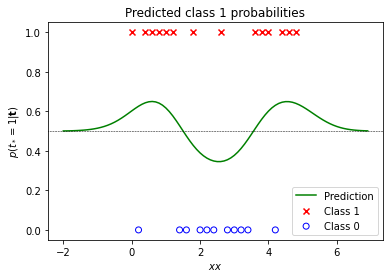

In [11]:
pt_test = predict_pt(X_test, X, t, theta)

plot_data_1D(X, t)
plt.plot(X_test, pt_test, label='Prediction', color='green')
plt.axhline(0.5, X_test.min(), X_test.max(), color='black', ls='--', lw=0.5)
plt.title('Predicted class 1 probabilities')
plt.xlabel('$x$')
plt.ylabel('$p(t_*=1|\mathbf{t})$')
plt.legend();

We can use the logit variances returned by `predict_a` to estimate the uncertainty of predictions. Uncertainty increases in regions with little or no training data as can bee seen in the following plot:

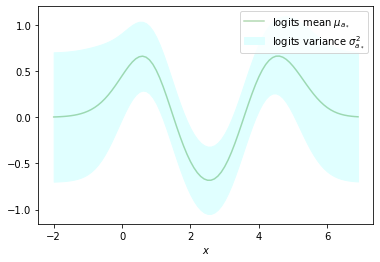

In [12]:
a_test_mu, a_test_var = predict_a(X_test, X, t, theta)

a_test_mu = a_test_mu.ravel()
a_test_var = a_test_var.ravel()

plt.plot(X_test, a_test_mu, label='logits mean $\mu_{a_*}$', color='green', alpha=0.3)
plt.fill_between(X_test.ravel(), 
                 a_test_mu + a_test_var, 
                 a_test_mu - a_test_var, 
                 label='logits variance $\sigma^2_{a_*}$', 
                 color='lightcyan')
plt.xlabel('$x$')
plt.legend();

### Comparison with `GaussianProcessClassifier`

A comparison with the results obtained by fitting a `GaussianProcessClassifier` (GPC) shows they are identical (or very close). This is the case for the optimized kernel parameters

In [13]:
rbf = ConstantKernel(1.0) * RBF(length_scale=1.0)
gpc = GaussianProcessClassifier(kernel=rbf)

gpc.fit(X, t.ravel())

# Obtain optimized kernel parameters
sklearn_theta_0 = gpc.kernel_.k2.get_params()['length_scale']
sklearn_theta_1 = np.sqrt(gpc.kernel_.k1.get_params()['constant_value'])

sklearn_theta_0, sklearn_theta_1, -gpc.log_marginal_likelihood_value_
print(f'Optimized theta = [{sklearn_theta_0:.3f}, {sklearn_theta_1:.3f}], negative log likelihood = {-gpc.log_marginal_likelihood_value_:.3f}')

Optimized theta = [0.715, 0.836], negative log likelihood = 17.002


as well as for the predicted class 1 probabilities. Minor differences mainly arise from the fact that `GaussianProcessClassifier` uses a numerically more stable implementation and that it computes the gradients of the log likelihood analytically.

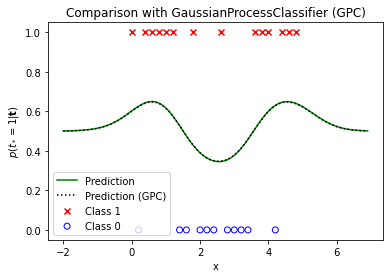

In [14]:
pt_test_gpc = gpc.predict_proba(X_test.reshape(-1, 1))[:,1]

plot_data_1D(X, t)
plt.plot(X_test, pt_test, label='Prediction', color='green')
plt.plot(X_test, pt_test_gpc, label='Prediction (GPC)', color='black', ls=':')
plt.title('Comparison with GaussianProcessClassifier (GPC)')
plt.xlabel('x')
plt.ylabel('$p(t_*=1|\mathbf{t})$')
plt.legend();

### 2D example

The minimal implementation can also be used for higher-dimensional input data. Let's use [make_moons](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) to generate a 2D training dataset. 

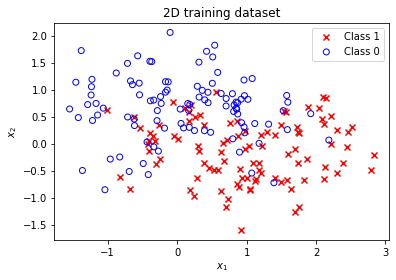

In [ ]:
X, t = make_moons(200, noise=0.5, random_state=1)
t = t.reshape(-1, 1)

plot_data_2D(X, t)
plt.title('2D training dataset')
plt.legend();

Optimized kernel parameters are obtained by minimizing the negative log likelihood of the new training dataset.

In [ ]:
res = minimize(nll_fn(X, t), [1, 1],
               bounds=((1e-3, None), (1e-3, None)),
               method='L-BFGS-B')

theta = res.x

print(f'Optimized theta = [{theta[0]:.3f}, {theta[1]:.3f}], negative log likelihood = {res.fun:.3f}')

Optimized theta = [1.347, 3.362], negative log likelihood = 93.434


Again, a comparison with `GaussianProcessClassifier` shows that optimization results are very close.

In [ ]:
rbf = ConstantKernel(1.0) * RBF(length_scale=1.0)
gpc = GaussianProcessClassifier(kernel=rbf)

gpc.fit(X, t.ravel())

# Obtain optimized kernel parameters
sklearn_theta_0 = gpc.kernel_.k2.get_params()['length_scale']
sklearn_theta_1 = np.sqrt(gpc.kernel_.k1.get_params()['constant_value'])

print(f'Optimized theta = [{sklearn_theta_0:.3f}, {sklearn_theta_1:.3f}], negative log likelihood = {-gpc.log_marginal_likelihood_value_:.3f}')

Optimized theta = [1.346, 3.360], negative log likelihood = 93.434


This is also the case for the predicted class 1 probabilities shown in the following contour plots. The black dashed line represents the decision boundary at $p(t_*=1 \mid \mathbf{t}) = 0.5$. The results obtained with the minimal implementation

In [ ]:
grid_x, grid_y = np.mgrid[-4:4:200j, -4:4:200j]
grid = np.stack([grid_x, grid_y], axis=-1)

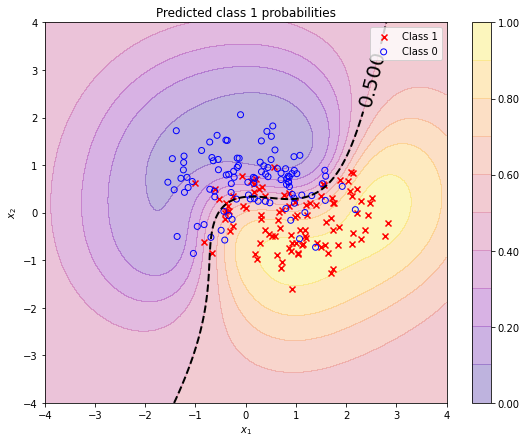

In [ ]:
pt_test = predict_pt(grid.reshape(-1, 2), X, t, theta).reshape(*grid_x.shape)

plt.figure(figsize=(9, 7))
plot_pt_2D(grid_x, grid_y, pt_test)
plot_db_2D(grid_x, grid_y, pt_test, decision_boundary=0.5)
plot_data_2D(X, t)
plt.title('Predicted class 1 probabilities')
plt.legend();

are almost identical with the results obtained with a `GaussianProcessClassifier`. A quantive evaluation of the differences is omitted.

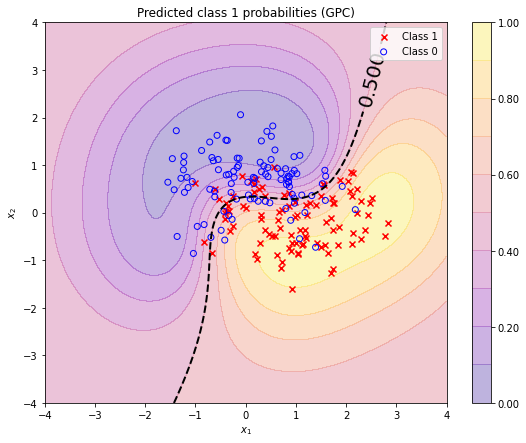

In [ ]:
pt_test_gpc = gpc.predict_proba(grid.reshape(-1, 2))[:, 1].reshape(*grid_x.shape)

plt.figure(figsize=(9, 7))
plot_pt_2D(grid_x, grid_y, pt_test_gpc)
plot_db_2D(grid_x, grid_y, pt_test_gpc, decision_boundary=0.5)
plot_data_2D(X, t)
plt.title('Predicted class 1 probabilities (GPC)')
plt.legend();

We can again use the logit variances returned by `predict_a` as a measure of model uncertainty or (inverse) model confidence. The model is more confident within the training data region than outside this region. When moving along the decision boundary (dashed black line) the predicted class 1 probability is always 0.5 but with varying confidence.

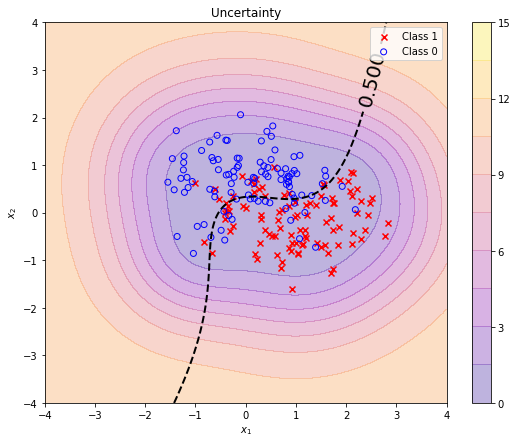

In [ ]:
a_test_var = predict_a(grid.reshape(-1, 2), X, t, theta)[1].reshape(*grid_x.shape)

plt.figure(figsize=(9, 7))
plt.contourf(grid_x, grid_y, a_test_var, alpha=0.3, cmap='plasma', levels=np.linspace(0, 15, 11))
plt.colorbar()
plot_db_2D(grid_x, grid_y, pt_test, decision_boundary=0.5)
plot_data_2D(X, t)
plt.title('Uncertainty')
plt.legend();

## References

\[1\] Kevin P. Murphy. [Machine Learning, A Probabilistic Perspective](https://mitpress.mit.edu/books/machine-learning-0), Chapter 15.  
\[2\] Christopher M. Bishop. [Pattern Recognition and Machine Learning](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf), Chapter 6.  
\[3\] Carl Edward Rasmussen and Christopher K. I. Williams. [Gaussian Processes for Machine Learning](http://www.gaussianprocess.org/gpml/).  